# DCGAN for MNIST (PyTorch)

arXiv: https://arxiv.org/abs/1511.06434

<img src="https://lh3.googleusercontent.com/M0D8jzjxyELjUFLVyZYF0UQVuYyLywwIorNRhyOwSeOsATqK_tOZS3cHAnHZSP5I-fmjSCFGB5Ztrxmd7SJpY2amIXOox7H_OVZhGZMqdGk5yUcrDK4Qh5941rMLfW_N67eNAyetS0lB6LlAShsdtqGJCfBrW5a7EBXJnmpM0v640_5-xFDgsxIaC5IliQqSxoz5cYhK14d3tG2V_Qa39CZ4yKlQNnZb0OhWRTezWoFQ3uZdK2RQHQ22PA3CrEW27kTVl95688fhA1EKvZloEZ7YZolxErdsx9Lc3zcE8kiI0gmqErKSsOOImwnL9ESC6rPosze4CSvs8-bSUOLXMyO8fQIDvObuRFfYT6TAflAYSp8PXCevA2LhvUCFat5YV5N6XpFmKoZam6w-lX8koEEeZI6djv8z5eETO3ab1Fhn7_UB1hper6kScrtj_4CRdeP_mvuALhRQvEB81_jV6N5KIFTJ2b7oCoo8to32XZvmk42w6IR8WasMtOQJB3yeKWY5mGAtoLOpuJ4H7r0KAXxbaHpDvltlIR227Ria2-7FSfSJTnaA3bv1MjHpLALaNnelZAwySJynzP0lof8kz9EiQCsjSL2TN-pudLC7jWHnyy-3FAKuj6sK=w807-h208-no">

<img src="https://lh3.googleusercontent.com/CqWKmMExGj3Ws9_vYROf2hnnV-HH5hlzvga0Dv_NrHXZKTwoSFWNZ4GO3ee9dVar-kCZmNkpLxkTZ9dLQj9uKeY__ys608i7jfWQqoIRrF2NU-ESZBiWbSxqeEwOICy-W-oWYDAK9Cxse4JPOoWOxFrfaMaNg-cC7UsJCa-PTtt8G11wENorShWIaa2_2dAwn92kaPj8bABqKLRuDEcOxwLdZpnGQOWZPRNgVprefoStGMnfpyRXb9fx-yoBhgSExMv-ybPZLbbymZ8PdMY8bCiNZZ0MRvjvRe-hYGJ_4fWwjmNRaB2ixKLjaaM0Ha2xLA3G_zbpfEo9ygLGIufntEWX6M3mXz-ctK3QrninW3Bfia1IYNQFKJUVnaGvZf6-bFswghn-ody073j89m6fYYysYrVzxxE9HQJeKGuwQKBkG1e7mG1PPwnr-hovxLiHRduMmi0BjNYxOtSYkffBPYzR9n8h66qC-AepoKAGO-Z7LBAuBKpwflhih1Ho9ttBRxBYTwkVeYOMIV8aQkNNY9CKbC-VazHnN7x-eWV0us2tDrJCOcYU3wjBMi-76oalxldFxQQ9MQy1x5SWkiI6vEW_hCbaAlWGJB3bud91PbciIuTk-LIH9Nh4=w805-h350-no">

Deep Convolution GANに以下の改善を行う。
- すべてのプーリングレイヤを strided convolutions(discriminator)と fractional-stirided convolutions(generator)に変更する。
- generator と discriminator に batchnormを使う。
- 全結合隠れ層を取り除く。
- ReLU 活性関数を generatorで使う。ただし、output層は tanhを使う。
- LeakyReLU活性関数をdiscriminatorのすべての層で使う。

もとい！

公式チュートリアルにサンプルコードが公開されているので、それを参考に実装する。
- [examples/dcgan at master · pytorch/examples](https://github.com/pytorch/examples/tree/master/dcgan)

In [45]:
% matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t

from torchvision import datasets, models, transforms, utils
import torchvision.utils as vutils

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import os

## mnist datasetの準備

In [207]:
bs = 100
sz = 32

In [208]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Scale(sz),
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                   ])),
    batch_size=bs
)

## Model

In [246]:
nz = 100
ngf = 32
ndf = 32
nc = 1

In [263]:
'''Discriminater'''
class netD(nn.Module):
    def __init__(self):
        super(netD, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        #x = x.view(100, -1)
        x = self.main(x)
        return x

'''Generator'''
class netG(nn.Module):
    def __init__(self):
        super(netG, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf,nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # x = x.view(bs,100)
        x = self.main(x)
        x = x.view(-1, 1, sz, sz)
        return x

In [264]:
criteion = nn.BCELoss()
net_D = netD()
net_G = netG()

if torch.cuda.is_available():
    D = net_D.cuda()
    G = net_G.cuda()
    criteion = criteion.cuda()    

In [265]:
print(net_D)

netD (
  (main): Sequential (
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid ()
  )
)


In [266]:
print(net_G)

netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh ()
  )
)


In [267]:
optimizerD = optim.Adam(net_D.parameters(), lr = 0.00005)
optimizerG = optim.Adam(net_G.parameters(), lr = 0.00005)

## Train

In [268]:
input = t.FloatTensor(bs, 1, sz, sz)
noise = t.FloatTensor(normal(0, 1,(bs, 100, 1, 1)))
fixed_noise = t.FloatTensor(bs, 100, 1, 1).normal_(0, 1)
label = t.FloatTensor(bs)

real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

In [269]:
niter = 4000

In [270]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real (data)
        net_D.zero_grad()
        real, _ = data
        input.data.resize_(real.size()).copy_(real)
        label.data.resize_(bs).fill_(real_label)
        output = net_D(input)
        errD_real = criteion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        #train with fake (generated)
        noise.data.resize_(bs, 100, 1, 1)
        noise.data.normal_(0, 1)
        fake = net_G(noise)
        label.data.fill_(fake_label)
        output = net_D(fake.detach())
        errD_fake = criteion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_G.zero_grad()
        label.data.fill_(real_label)
        output = net_D(fake)
        errG = criteion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                 % (epoch, niter, i, len(dataloader),
                   errD.data[0], errG.data[0],  D_x, D_G_z1, D_G_z2))
    if epoch % 10 == 0:
        fake = net_G(fixed_noise)
        vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png'
                              % ('results', epoch),normalize=True)

[0/4000][0/600] Loss_D: 1.4583 Loss_G: 0.6733 D(x): 0.4899 D(G(z)): 0.5208 / 0.5122
[0/4000][100/600] Loss_D: 0.8505 Loss_G: 1.0397 D(x): 0.7121 D(G(z)): 0.3881 / 0.3562
[0/4000][200/600] Loss_D: 0.7463 Loss_G: 1.4093 D(x): 0.6796 D(G(z)): 0.2835 / 0.2488
[0/4000][300/600] Loss_D: 0.4877 Loss_G: 1.7799 D(x): 0.7802 D(G(z)): 0.2050 / 0.1744
[0/4000][400/600] Loss_D: 0.2743 Loss_G: 2.1677 D(x): 0.8965 D(G(z)): 0.1476 / 0.1226
[0/4000][500/600] Loss_D: 0.2653 Loss_G: 2.4174 D(x): 0.8809 D(G(z)): 0.1229 / 0.0918
[1/4000][0/600] Loss_D: 0.3351 Loss_G: 2.3313 D(x): 0.8596 D(G(z)): 0.1513 / 0.1084
[1/4000][100/600] Loss_D: 0.1897 Loss_G: 2.5091 D(x): 0.9367 D(G(z)): 0.1142 / 0.0856
[1/4000][200/600] Loss_D: 0.1651 Loss_G: 3.0968 D(x): 0.9173 D(G(z)): 0.0717 / 0.0505
[1/4000][300/600] Loss_D: 0.1211 Loss_G: 3.2050 D(x): 0.9333 D(G(z)): 0.0482 / 0.0489
[1/4000][400/600] Loss_D: 0.0623 Loss_G: 3.7729 D(x): 0.9775 D(G(z)): 0.0377 / 0.0286
[1/4000][500/600] Loss_D: 0.0437 Loss_G: 4.2053 D(x): 0.97

[16/4000][0/600] Loss_D: 0.0167 Loss_G: 5.8045 D(x): 0.9914 D(G(z)): 0.0077 / 0.0036
[16/4000][100/600] Loss_D: 0.0135 Loss_G: 6.2537 D(x): 0.9913 D(G(z)): 0.0038 / 0.0024
[16/4000][200/600] Loss_D: 0.0278 Loss_G: 4.4945 D(x): 0.9992 D(G(z)): 0.0266 / 0.0124
[16/4000][300/600] Loss_D: 0.0314 Loss_G: 3.8853 D(x): 0.9917 D(G(z)): 0.0191 / 0.0263
[16/4000][400/600] Loss_D: 0.0183 Loss_G: 5.9444 D(x): 0.9889 D(G(z)): 0.0063 / 0.0031
[16/4000][500/600] Loss_D: 0.0129 Loss_G: 5.4947 D(x): 0.9972 D(G(z)): 0.0100 / 0.0055
[17/4000][0/600] Loss_D: 0.0167 Loss_G: 4.2397 D(x): 0.9957 D(G(z)): 0.0122 / 0.0176
[17/4000][100/600] Loss_D: 0.0134 Loss_G: 6.7091 D(x): 0.9904 D(G(z)): 0.0027 / 0.0014
[17/4000][200/600] Loss_D: 0.0096 Loss_G: 5.5225 D(x): 0.9992 D(G(z)): 0.0087 / 0.0054
[17/4000][300/600] Loss_D: 0.0135 Loss_G: 5.8190 D(x): 0.9934 D(G(z)): 0.0058 / 0.0040
[17/4000][400/600] Loss_D: 0.0163 Loss_G: 5.0729 D(x): 0.9993 D(G(z)): 0.0155 / 0.0072
[17/4000][500/600] Loss_D: 0.0065 Loss_G: 6.516

[31/4000][500/600] Loss_D: 0.0124 Loss_G: 5.5754 D(x): 0.9950 D(G(z)): 0.0071 / 0.0060
[32/4000][0/600] Loss_D: 0.0533 Loss_G: 3.6932 D(x): 0.9795 D(G(z)): 0.0271 / 0.0456
[32/4000][100/600] Loss_D: 0.0232 Loss_G: 4.5650 D(x): 0.9920 D(G(z)): 0.0133 / 0.0135
[32/4000][200/600] Loss_D: 0.0148 Loss_G: 5.3049 D(x): 0.9989 D(G(z)): 0.0134 / 0.0074
[32/4000][300/600] Loss_D: 0.0732 Loss_G: 4.7389 D(x): 0.9740 D(G(z)): 0.0164 / 0.0116
[32/4000][400/600] Loss_D: 0.0513 Loss_G: 6.6460 D(x): 0.9592 D(G(z)): 0.0031 / 0.0017
[32/4000][500/600] Loss_D: 0.1010 Loss_G: 4.3334 D(x): 0.9533 D(G(z)): 0.0141 / 0.0149
[33/4000][0/600] Loss_D: 0.0777 Loss_G: 3.4117 D(x): 0.9807 D(G(z)): 0.0384 / 0.0466
[33/4000][100/600] Loss_D: 0.0746 Loss_G: 5.9954 D(x): 0.9436 D(G(z)): 0.0060 / 0.0042
[33/4000][200/600] Loss_D: 0.0322 Loss_G: 4.9772 D(x): 0.9902 D(G(z)): 0.0193 / 0.0087
[33/4000][300/600] Loss_D: 0.0297 Loss_G: 4.8024 D(x): 0.9937 D(G(z)): 0.0228 / 0.0112
[33/4000][400/600] Loss_D: 0.0661 Loss_G: 3.584

[47/4000][400/600] Loss_D: 0.0364 Loss_G: 5.5982 D(x): 0.9765 D(G(z)): 0.0102 / 0.0081
[47/4000][500/600] Loss_D: 0.1097 Loss_G: 6.7903 D(x): 0.9357 D(G(z)): 0.0017 / 0.0024
[48/4000][0/600] Loss_D: 0.1174 Loss_G: 6.3698 D(x): 0.9160 D(G(z)): 0.0040 / 0.0031
[48/4000][100/600] Loss_D: 0.0345 Loss_G: 4.7988 D(x): 0.9875 D(G(z)): 0.0197 / 0.0133
[48/4000][200/600] Loss_D: 0.0250 Loss_G: 4.8016 D(x): 0.9975 D(G(z)): 0.0221 / 0.0104
[48/4000][300/600] Loss_D: 0.0442 Loss_G: 4.4848 D(x): 0.9795 D(G(z)): 0.0159 / 0.0144
[48/4000][400/600] Loss_D: 0.0999 Loss_G: 6.0857 D(x): 0.9431 D(G(z)): 0.0061 / 0.0034
[48/4000][500/600] Loss_D: 0.0493 Loss_G: 4.6668 D(x): 0.9740 D(G(z)): 0.0151 / 0.0122
[49/4000][0/600] Loss_D: 0.0881 Loss_G: 4.1870 D(x): 0.9700 D(G(z)): 0.0379 / 0.0221
[49/4000][100/600] Loss_D: 0.0571 Loss_G: 4.5915 D(x): 0.9712 D(G(z)): 0.0188 / 0.0151
[49/4000][200/600] Loss_D: 0.0109 Loss_G: 5.8679 D(x): 0.9965 D(G(z)): 0.0073 / 0.0037
[49/4000][300/600] Loss_D: 0.0635 Loss_G: 6.396

[63/4000][300/600] Loss_D: 0.0443 Loss_G: 4.4225 D(x): 0.9757 D(G(z)): 0.0177 / 0.0230
[63/4000][400/600] Loss_D: 0.0669 Loss_G: 6.5660 D(x): 0.9518 D(G(z)): 0.0023 / 0.0020
[63/4000][500/600] Loss_D: 0.0165 Loss_G: 6.8555 D(x): 0.9863 D(G(z)): 0.0018 / 0.0018
[64/4000][0/600] Loss_D: 0.0581 Loss_G: 4.6683 D(x): 0.9705 D(G(z)): 0.0233 / 0.0126
[64/4000][100/600] Loss_D: 0.0131 Loss_G: 5.4762 D(x): 0.9974 D(G(z)): 0.0104 / 0.0058
[64/4000][200/600] Loss_D: 0.0259 Loss_G: 6.0072 D(x): 0.9839 D(G(z)): 0.0065 / 0.0038
[64/4000][300/600] Loss_D: 0.0644 Loss_G: 3.4501 D(x): 0.9873 D(G(z)): 0.0463 / 0.0522
[64/4000][400/600] Loss_D: 0.0352 Loss_G: 6.9611 D(x): 0.9728 D(G(z)): 0.0040 / 0.0021
[64/4000][500/600] Loss_D: 0.0190 Loss_G: 6.5146 D(x): 0.9851 D(G(z)): 0.0016 / 0.0025
[65/4000][0/600] Loss_D: 0.0354 Loss_G: 3.6836 D(x): 0.9959 D(G(z)): 0.0304 / 0.0339
[65/4000][100/600] Loss_D: 0.0475 Loss_G: 5.4622 D(x): 0.9833 D(G(z)): 0.0086 / 0.0077
[65/4000][200/600] Loss_D: 0.0581 Loss_G: 5.497

[79/4000][200/600] Loss_D: 0.0080 Loss_G: 6.1510 D(x): 0.9980 D(G(z)): 0.0059 / 0.0032
[79/4000][300/600] Loss_D: 0.0138 Loss_G: 7.5473 D(x): 0.9891 D(G(z)): 0.0011 / 0.0011
[79/4000][400/600] Loss_D: 0.0524 Loss_G: 4.7939 D(x): 0.9791 D(G(z)): 0.0230 / 0.0139
[79/4000][500/600] Loss_D: 0.1064 Loss_G: 7.5499 D(x): 0.9388 D(G(z)): 0.0007 / 0.0008
[80/4000][0/600] Loss_D: 0.0465 Loss_G: 2.8720 D(x): 0.9991 D(G(z)): 0.0435 / 0.0917
[80/4000][100/600] Loss_D: 0.0125 Loss_G: 5.8585 D(x): 0.9975 D(G(z)): 0.0098 / 0.0040
[80/4000][200/600] Loss_D: 0.0233 Loss_G: 5.1494 D(x): 0.9998 D(G(z)): 0.0225 / 0.0103
[80/4000][300/600] Loss_D: 0.1094 Loss_G: 5.9639 D(x): 0.9437 D(G(z)): 0.0045 / 0.0040
[80/4000][400/600] Loss_D: 0.0871 Loss_G: 3.9321 D(x): 0.9928 D(G(z)): 0.0739 / 0.0309
[80/4000][500/600] Loss_D: 0.0112 Loss_G: 9.3177 D(x): 0.9898 D(G(z)): 0.0003 / 0.0002
[81/4000][0/600] Loss_D: 0.0140 Loss_G: 6.6058 D(x): 0.9924 D(G(z)): 0.0055 / 0.0023
[81/4000][100/600] Loss_D: 0.0258 Loss_G: 5.131

[95/4000][100/600] Loss_D: 0.0342 Loss_G: 4.8496 D(x): 0.9990 D(G(z)): 0.0319 / 0.0146
[95/4000][200/600] Loss_D: 0.0306 Loss_G: 5.9187 D(x): 0.9890 D(G(z)): 0.0143 / 0.0043
[95/4000][300/600] Loss_D: 0.0116 Loss_G: 5.5698 D(x): 0.9991 D(G(z)): 0.0105 / 0.0097
[95/4000][400/600] Loss_D: 0.0103 Loss_G: 6.2059 D(x): 0.9961 D(G(z)): 0.0062 / 0.0036
[95/4000][500/600] Loss_D: 0.0045 Loss_G: 6.0662 D(x): 0.9984 D(G(z)): 0.0028 / 0.0033
[96/4000][0/600] Loss_D: 0.0059 Loss_G: 5.9425 D(x): 0.9984 D(G(z)): 0.0042 / 0.0038
[96/4000][100/600] Loss_D: 0.0466 Loss_G: 5.9024 D(x): 0.9725 D(G(z)): 0.0065 / 0.0058
[96/4000][200/600] Loss_D: 0.0318 Loss_G: 7.9483 D(x): 0.9833 D(G(z)): 0.0022 / 0.0006
[96/4000][300/600] Loss_D: 0.0112 Loss_G: 10.0428 D(x): 0.9898 D(G(z)): 0.0002 / 0.0001
[96/4000][400/600] Loss_D: 0.0401 Loss_G: 6.0794 D(x): 0.9806 D(G(z)): 0.0136 / 0.0034
[96/4000][500/600] Loss_D: 0.0129 Loss_G: 6.0008 D(x): 0.9947 D(G(z)): 0.0063 / 0.0040
[97/4000][0/600] Loss_D: 0.0068 Loss_G: 5.99

[110/4000][500/600] Loss_D: 0.0082 Loss_G: 7.1025 D(x): 0.9947 D(G(z)): 0.0022 / 0.0015
[111/4000][0/600] Loss_D: 0.0069 Loss_G: 9.0722 D(x): 0.9942 D(G(z)): 0.0004 / 0.0002
[111/4000][100/600] Loss_D: 0.0064 Loss_G: 6.3419 D(x): 0.9995 D(G(z)): 0.0058 / 0.0033
[111/4000][200/600] Loss_D: 0.0168 Loss_G: 5.9142 D(x): 0.9999 D(G(z)): 0.0163 / 0.0054
[111/4000][300/600] Loss_D: 0.0095 Loss_G: 6.2018 D(x): 0.9972 D(G(z)): 0.0067 / 0.0031
[111/4000][400/600] Loss_D: 0.0448 Loss_G: 6.3646 D(x): 0.9674 D(G(z)): 0.0044 / 0.0028
[111/4000][500/600] Loss_D: 0.0558 Loss_G: 7.4167 D(x): 0.9743 D(G(z)): 0.0059 / 0.0041
[112/4000][0/600] Loss_D: 0.1838 Loss_G: 13.9284 D(x): 0.9066 D(G(z)): 0.0000 / 0.0000
[112/4000][100/600] Loss_D: 0.0308 Loss_G: 4.4620 D(x): 0.9907 D(G(z)): 0.0188 / 0.0210
[112/4000][200/600] Loss_D: 0.0435 Loss_G: 5.9615 D(x): 0.9724 D(G(z)): 0.0075 / 0.0039
[112/4000][300/600] Loss_D: 0.0082 Loss_G: 6.9072 D(x): 0.9939 D(G(z)): 0.0018 / 0.0018
[112/4000][400/600] Loss_D: 0.0857 

[126/4000][300/600] Loss_D: 0.0183 Loss_G: 5.8866 D(x): 0.9873 D(G(z)): 0.0036 / 0.0044
[126/4000][400/600] Loss_D: 0.1243 Loss_G: 5.9009 D(x): 0.9466 D(G(z)): 0.0130 / 0.0127
[126/4000][500/600] Loss_D: 0.0101 Loss_G: 6.2085 D(x): 0.9949 D(G(z)): 0.0047 / 0.0032
[127/4000][0/600] Loss_D: 0.0073 Loss_G: 7.6415 D(x): 0.9955 D(G(z)): 0.0024 / 0.0008
[127/4000][100/600] Loss_D: 0.0107 Loss_G: 7.7017 D(x): 0.9916 D(G(z)): 0.0016 / 0.0019
[127/4000][200/600] Loss_D: 0.0204 Loss_G: 6.2806 D(x): 0.9996 D(G(z)): 0.0193 / 0.0045
[127/4000][300/600] Loss_D: 0.0145 Loss_G: 5.6637 D(x): 0.9998 D(G(z)): 0.0141 / 0.0057
[127/4000][400/600] Loss_D: 0.0201 Loss_G: 5.0533 D(x): 0.9951 D(G(z)): 0.0148 / 0.0087
[127/4000][500/600] Loss_D: 0.0227 Loss_G: 4.3197 D(x): 0.9897 D(G(z)): 0.0116 / 0.0173
[128/4000][0/600] Loss_D: 0.0278 Loss_G: 10.5306 D(x): 0.9783 D(G(z)): 0.0005 / 0.0002
[128/4000][100/600] Loss_D: 0.0265 Loss_G: 5.8184 D(x): 0.9854 D(G(z)): 0.0079 / 0.0043
[128/4000][200/600] Loss_D: 0.0716 

[142/4000][100/600] Loss_D: 0.0397 Loss_G: 4.0267 D(x): 0.9965 D(G(z)): 0.0348 / 0.0233
[142/4000][200/600] Loss_D: 0.0613 Loss_G: 4.5401 D(x): 0.9721 D(G(z)): 0.0122 / 0.0183
[142/4000][300/600] Loss_D: 0.0188 Loss_G: 5.1746 D(x): 0.9938 D(G(z)): 0.0107 / 0.0092
[142/4000][400/600] Loss_D: 0.0054 Loss_G: 6.4890 D(x): 0.9983 D(G(z)): 0.0037 / 0.0024
[142/4000][500/600] Loss_D: 0.0383 Loss_G: 4.9180 D(x): 0.9786 D(G(z)): 0.0063 / 0.0107
[143/4000][0/600] Loss_D: 0.0094 Loss_G: 7.5428 D(x): 0.9946 D(G(z)): 0.0037 / 0.0013
[143/4000][100/600] Loss_D: 0.0194 Loss_G: 6.0826 D(x): 0.9985 D(G(z)): 0.0170 / 0.0093
[143/4000][200/600] Loss_D: 0.0140 Loss_G: 5.6264 D(x): 0.9951 D(G(z)): 0.0087 / 0.0063
[143/4000][300/600] Loss_D: 0.0182 Loss_G: 4.9479 D(x): 0.9919 D(G(z)): 0.0094 / 0.0119
[143/4000][400/600] Loss_D: 0.0174 Loss_G: 5.9416 D(x): 0.9885 D(G(z)): 0.0026 / 0.0042
[143/4000][500/600] Loss_D: 0.0114 Loss_G: 5.5360 D(x): 0.9985 D(G(z)): 0.0096 / 0.0089
[144/4000][0/600] Loss_D: 0.0277 L

[157/4000][500/600] Loss_D: 0.0152 Loss_G: 5.6168 D(x): 0.9900 D(G(z)): 0.0045 / 0.0051
[158/4000][0/600] Loss_D: 0.0325 Loss_G: 4.9181 D(x): 0.9924 D(G(z)): 0.0219 / 0.0139
[158/4000][100/600] Loss_D: 0.0195 Loss_G: 5.9961 D(x): 0.9920 D(G(z)): 0.0110 / 0.0045
[158/4000][200/600] Loss_D: 0.0143 Loss_G: 5.7493 D(x): 0.9955 D(G(z)): 0.0096 / 0.0049
[158/4000][300/600] Loss_D: 0.0139 Loss_G: 7.4042 D(x): 0.9888 D(G(z)): 0.0020 / 0.0011
[158/4000][400/600] Loss_D: 0.0503 Loss_G: 5.6597 D(x): 0.9666 D(G(z)): 0.0070 / 0.0070
[158/4000][500/600] Loss_D: 0.0554 Loss_G: 6.2117 D(x): 0.9617 D(G(z)): 0.0036 / 0.0035
[159/4000][0/600] Loss_D: 0.0023 Loss_G: 7.1288 D(x): 0.9991 D(G(z)): 0.0014 / 0.0020
[159/4000][100/600] Loss_D: 0.0198 Loss_G: 5.1193 D(x): 0.9990 D(G(z)): 0.0183 / 0.0114
[159/4000][200/600] Loss_D: 0.0460 Loss_G: 4.0124 D(x): 0.9994 D(G(z)): 0.0434 / 0.0279
[159/4000][300/600] Loss_D: 0.0124 Loss_G: 4.6961 D(x): 0.9990 D(G(z)): 0.0113 / 0.0116
[159/4000][400/600] Loss_D: 0.0451 L

KeyboardInterrupt: 

In [271]:
fake = net_G(fixed_noise)
vutils.save_image(fake.data[:64], '%s/fake_samples3.png' % 'results' ,normalize=True)

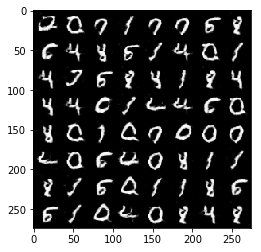

In [273]:
from PIL import Image
im = Image.open("results/fake_samples3.png", "r")
plt.imshow(np.array(im))